---
# NOTEBOOK 3 - INITIAL MODELING AND SECOND-ROUND DATA PROCESSING / CLEANING
---

# Project 3:
# 'Wait, was that a joke?' - Language Model Identification of Absurdist Humor and Satire
## Daniel Rossetti

# Problem Statement:
This project is conducted from the standpoint of a data scientist hired by a university researching the relatability of AI chat bots and their ability to identify nuances of human language, particularly humor.  Some statements are considered funny, but are not necessarily presented as a joke.  The task is to come up with a language model that can identify humorous strings of text which are not structed in the format of a joke but are of similar structure to factual information.  Text must sourced to train and test a model which can differentiate between humorous and non-humorous statements.

# Project Approach:
The Onion is a satirical news organization which produces news titles and news stories often relevant to real, current events that are satirical or would otherwise be classified as absurdist humor.  For clarity **news articles and titles from The Onion are not real.**  The tiles are however, formated in the format of actual news titles and articles which, from legitimate news agencies - are not humorous.

Comparing the titles of posts to the subreddit r/TheOnion against the subreddit r/worldnews provides a way to compare strings of text which share many of the same formatting characteristics, but have completely different goals with respect to humor.

These subreddits are to be scraped and the data processed to see if a language model can idenifty the humorous Onion titles from the factual World News titles.

# Data Cleaning and Pre-Processing Approach
In this notebook the news titles from both subreddits are explored and cleaned.  Ideally, when making this comparison, as little processing would be done as possible.  However, as will be shown below, the data collected suffer from a few issues:
* Not all of the titles sourced through the 'pushshift' API are legitimate Onion or World News posts given that users are allowed to contribute what they want, and the pushshift API sources the information before the subreddit moderators are able to remove illegitimate news titles
* Not all of the titles sourced are in English, which if not removed, would make a language model far more difficult to train
* The data contain character errors 
* The titles contain information that would directly indidcate which subreddit the title is from

With this, the data cleaning and pre-processing was broken down into two stages:
* A first stage - **ocurring in a previous notebook** - where only issues that would severly affect the model performance were removed such as bad characters, different languages
    * After this, a few models were run to ensure that the models were capable of running on the collected data, and to baseline their performance on minimally processed data.  The hope in doing this was to uncover any issues that would prevent the word vectorizing or modeling methods from working prpoperly so that they could be identified early.
* **A second stage of processing was performed in this notebook** and focused on isolating the true title text as much as possible and removing any identifiers in the titles that the model could be trained to recognize to immediately classify the model without considering the rest of its content.  

Again, the goal is to process the titles in such a way that the true news article title content is isolated for comparison (as best as possible without manually examining and cleaning each title).

# Train-Test-Splits, Model Retraining, Data Leakage Concerns, and Hold-Out Datasets

In this notebook and the previous notebook, ALL data are processed BEFORE the train-test-split occurs.  The data are processed, and a models are run in between pre-processing stages to be retrained after the second stage of processing.

This presents a concern for data leakage.  However, as the ultimate goal of this task is to focus on the conent in the subreddit posts which are the ACTUAL titles of the news articles (and not the names of the news agencies, emjois, etc.), it will be argued that processing all data simultaneously (including those which will end up in the test dataset) is acceptable as long as the processing/cleaning only serves to isolate the true title content.  On the other hand, viewing titles that would end up in the test dataset and creating features which would specifically identify humor would not be acceptable and will be avoided.

Put differntly, this task is going beyond the subreddit designation and is focusing on humor.  Part of the challenge is to make this less about differntiating between subreddits and more about truly comapable pure news article titles.  Thus, viewing data that end up being in the test dataset for the purpose stripping away features which ONLY serve to idenify the reddit and have notthing to do with the news article title should be fair game for removal.

With all of that being established, a hold-out dataset will be collected and run against the final model to further validate model performance.



# CONTENT WARNING - INAPPROPRIATE LANGUAGE
The folowing should be noted before continuing with this notebook:
* The subreddit posts collected (and therefore shown or presented in these notebooks) may contian profanity or vulgarities, or be otherwise NSFW (Not Safe for Work) due to the fact that the posts are collected before the subreddit mderators can remove them, and that The Onion commonly uses this language for the sake of humor
* The subreddit posts were not generated by the author of this project/notebooks and do not represent his opinions


---
# APPENDIX

In [1]:
# STANDARD IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import re

    # DATA PREP SPECIALLY FOR THE FINAL CLEANING FUNCTION
import html
    # Language Detection Imports:
    # SOURCE:  https://spacy.io/
    # SOURCE:  https://pypi.org/project/spacy-langdetect/
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

# LANGUAGE DATA PREP
from nltk.stem import WordNetLemmatizer

# MODELS:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

# METRICS & VISUALIZATIONS
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             recall_score, precision_score)

from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# 1 - Read Previosuly Cleaned Data

In [2]:
reddit =pd.read_csv('../data/reddit_clean.csv')
print(reddit.shape)
reddit.head(2)

(10367, 2)


subreddit                                              title
0  TheOnion  Idiot Tornado Tears Harmlessly Through Empty F...
1  TheOnion  New Texas Law Requires Schools To Display Imag...

# 2 - Preprocessing

## 2.1 - Encode Target Variable - Positive Class: TheOnion | Negative Class: WorldNews

In [3]:
X = reddit['title']
y = reddit['subreddit'].map({'TheOnion': 1, 'worldnews': 0})

## 2.2 - Train Test Split:  80/20, Random State: 0

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 3 - Initial Modeling

In [5]:
'''
This cell can be re-run as-needed to reset the metrics dataframe.
'''

metrics = pd.DataFrame()

In [6]:
'''
This cell will seek to define a function that will preformance metrics to a 'metrics' dataframe.

This can be called for each model to add the model's performance metrics to the running list of 
models and metrics in the global 'metrics" dataframe'
'''

def eval_metrics(X_train, y_train, X_test, y_test, preds, model, name):
    
    # Create all important scores from the arguments above
    tr_acc = round(model.score(X_train, y_train), 4),
    ts_acc =  round(model.score(X_test, y_test), 4),
    prec = round(precision_score(y_test, preds), 4),
    recall = round(recall_score(y_test, preds), 4)  

    # Create a temporary dictionary to store the scores created above                 
    temp_dict = {
        'Training Accuracy': tr_acc,
        'Testing Accuracy':  ts_acc,
        'Precision Score': prec,
        'Recall Score': recall
    }
    
    # Create a temporary dataframe to eventually be added to the global metrics dataframe
    df = pd.DataFrame(temp_dict, index = [name])
    
    # Concatenate the global metrics dataframe with the one just produced
    #  Source for calling a global variable:  https://stackoverflow.com/questions/10588317/python-function-global-variables
    global metrics
    return pd.concat([metrics, df])   

## 3.1 - Null Model (Target Variable Distributions)

In [7]:
y.value_counts(normalize=True)

1    0.509501
0    0.490499
Name: subreddit, dtype: float64

## 3.2 - Initial Default Parameter Bagging Classifier

### 3.2.1 - With CountVectorizer

In [8]:
# Create Pipeline with count vectorizer and bagging classifier
bag_pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_cvec.fit(X_train, y_train)

# Create predictions:
preds_bag_cvec = bag_pipe_cvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_cvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_cvec.score(X_test, y_test)}')

Training Data Accuracy: 0.987941637525624
Testing Data Accuracy: 0.8206364513018322


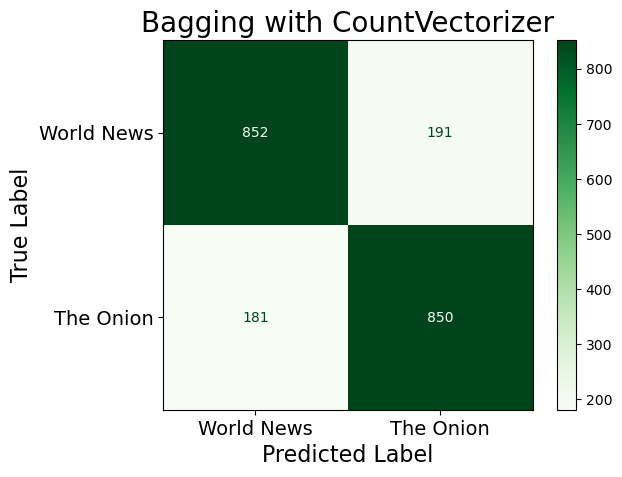

In [9]:
# Creating Metrics
tn_bag_cvec, fp_bag_cvec, fn_bag_cvec, tp_bag_cvec = confusion_matrix(y_test, preds_bag_cvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
#  Source for color map name:  https://i.stack.imgur.com/cmk1J.png
ConfusionMatrixDisplay.from_estimator(bag_pipe_cvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [10]:
#dict_ = 
metrics = eval_metrics(X_train, y_train, X_test, y_test, preds_bag_cvec, bag_pipe_cvec, 'bagging_cvec')
metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9879            0.8206           0.8165   

              Recall Score  
bagging_cvec        0.8244

### 3.2.2 - With TFIDF Vectorizer

In [11]:
# Create Pipeline with TFIDF vectorizer and bagging classifier
bag_pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_tvec.fit(X_train, y_train)

# Create predictions:
preds_bag_tvec = bag_pipe_tvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_tvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_tvec.score(X_test, y_test)}')

Training Data Accuracy: 0.9867358012781864
Testing Data Accuracy: 0.8138862102217936


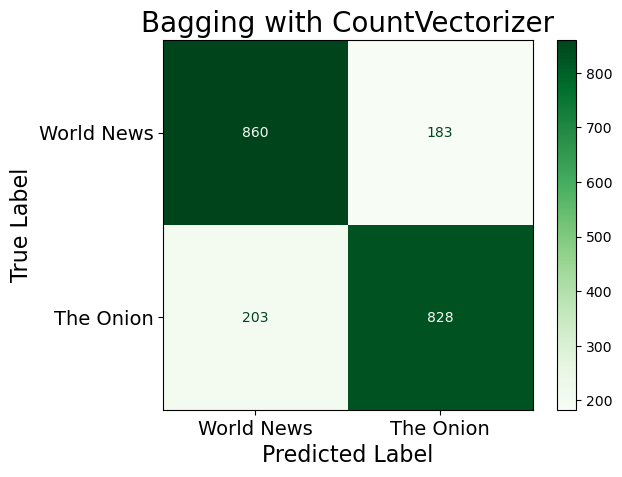

In [12]:
# Creating Metrics
tn_bag_tvec, fp_bag_tvec, fn_bag_tvec, tp_bag_tvec = confusion_matrix(y_test, preds_bag_tvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
ConfusionMatrixDisplay.from_estimator(bag_pipe_tvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [13]:
#dict_ = 
metrics = eval_metrics(X_train, y_train, X_test, y_test, preds_bag_tvec, bag_pipe_tvec, 'bagging_tvec')
metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9879            0.8206           0.8165   
bagging_tvec             0.9867            0.8139           0.8190   

              Recall Score  
bagging_cvec        0.8244  
bagging_tvec        0.8031

## 3.3 - Decision Tree Classifier

Because the Bagging Classifier is using decision trees as the default base estimator, running a full decision tree may provide insight into what the model is doing.

The DecisionTreeClassifier can provide a visual of the decision tree which will indicate how the features are pliting the data at each node.

In [14]:
tree_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tree', DecisionTreeClassifier(max_depth = 20))
])

tree_pipe.fit(X_train, y_train)
preds_tree_20_cvec = tree_pipe.predict(X_test)

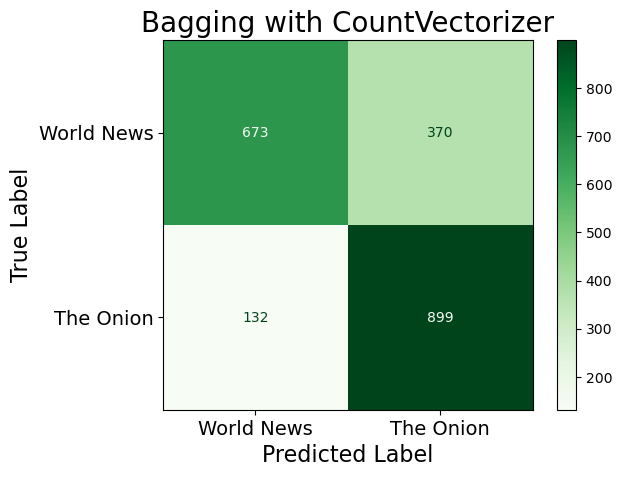

In [15]:
# Setting Up Confusion Matrix
ConfusionMatrixDisplay.from_estimator(tree_pipe, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

In [16]:
eval_metrics(X_train, y_train, X_test, y_test, preds_tree_20_cvec, tree_pipe, 'tree_20_cvec')
# metrics

Training Accuracy  Testing Accuracy  Precision Score  \
bagging_cvec             0.9879            0.8206           0.8165   
bagging_tvec             0.9867            0.8139           0.8190   
tree_20_cvec             0.7893            0.7580           0.7084   

              Recall Score  
bagging_cvec        0.8244  
bagging_tvec        0.8031  
tree_20_cvec        0.8720

In [17]:
plt.figure(figsize=(200, 120))
plot_tree(tree_pipe[1], feature_names=tree_pipe[0].get_feature_names_out(), filled = True);

# 4 - Secondary Data Cleaning
In the preceeding notebook '2-Data_Cleaning', a few characteristics were examined and decidely left in the dataset:
* Hashtags were left in the dataset as they were present in both The Onion data and the World News data
* Both 'The Onion' and 'World News' were mentioned in a subset of the titles, likely making it easy for them to be identified as belonging to the corresponding subreddits

#### TItles matching these characteristics will be removed.
## Reasoning:
As it was invesitgated above, classifiers using some form of decision tree model were heavily utilized, and will continue to be heavily utilized in some for m or another going forward.  By looking at the decision tree, decisions are being made based on the presence of key words and phases.  For words like "onion" and "worldnews," the model can very likely train to idenify these titles and correctly categorize them with ease.  The problem that this creates however, is that the language of the title itself (where the satire or absurdist humor may actually be occuring) could be of little or no importance to the model and prevents the model truly attempting to identify humor.

In the case of the hashtags, this is extra information that does not serve as part of the humor and may further complicate efforts to include things such as sentiment analysis and subjectivity analysis both of which may play a role in identifying humor versus actual news.  This model will seek to incorporate those features into subsequent models.

In [18]:
# Source to reset pandas column width:  https://pandas.pydata.org/docs/reference/api/pandas.reset_option.html
# Source to widen pandas columns:  https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.reset_option('all')
pd.set_option('display.max_colwidth', 200)

C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\Dan\anaconda3\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


## 4.1 - Process or Drop Titles Directly Referencing the Subreddit Name

In [19]:
# Find all titles with some variation of World News

# The regex code here was created with the help of the following sources:
# Source:  https://stackoverflow.com/questions/18402416/regular-expression-to-match-a-word-or-its-prefix
# Source:  https://stackoverflow.com/questions/20462834/python-using-str-replace-with-a-wildcard
# Source:  https://regex101.com/
# Source:  https://stackoverflow.com/questions/5633533/regular-expression-for-matching-parentheses
# Source:  https://stackoverflow.com/questions/4007302/regex-how-to-match-an-optional-character
# Source:  https://www.regular-expressions.info/optional.html
# Source:  https://stackoverflow.com/questions/9655164/regex-ignore-case-sensitivity
# Source:  https://stackoverflow.com/questions/34583904/javascript-regex-ignore-case-for-specific-capture-group
# Source:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation

'''
The regex expression below will (in order or characters left to right):
- outer () - says to match all inside the parentheses
- /{0,1}r{0,1}/{0,1} - find a string with or without each of  /, r, and /
- [wW]orld[nN]ews - find worldnew optionally capitalized
- ( Live Thread: )? - it may have this text after it, if so find it, if not, don't
- | either or
- outer () - says to match all inside the parenthese
- \( - backslash tells it to treat left parenthesis as character
- Thread # - where it says 'Thread #'
- \d{1,} - \d any digit, {1,} at least one character long
- \) - backslash tells it to treat right parenthesis as character
'''

# Create the regex string
regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'

print(reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].shape)
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].head()

(22, 2)


subreddit  \
3289   TheOnion   
5451  worldnews   
5641  worldnews   
5711  worldnews   
5938  worldnews   

                                                                                                                                                                                                        title  
3289  U.S. diplomats forced by China to undergo anal swab testing for Covid-19 after Biden raised "fundamental concerns" about Beijing's "coercive and unfair economic practices and human rights abuses i...  
5451                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 425, Part 1 (Thread #566)  
5641                                          r/worldnews Some have forgiven him. Some can’t. Truck driver who killed 16 in Humboldt Broncos crash says ‘as long as I’m alive, I’m going to think about them’  
5711                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 424, Part 1 (Thread #565)  
5938                                                                                                                      /r/WorldNews Live Thread: Russian Invasion of Ukraine Day 423, Part 1 (Thread #564)

#### OBSERVATIONS:
* As was observed in the preceeding notebook, many of the titles have the exact same title name.  This will present the same problem as having 'worldnews' in the title.  It is presumaly very easy for the model to train to identify these titles
* The first title is actually from The Onion data that were collected, however, it is no longer on the reddit, and appears to not be a legitimate title. It will be removed
* Index number 5786 is a legitimate new title and will be kept, and 'r/worldnews' will be removed

In [20]:
# Create the index list to drop and drop the index of the title to be kept from the Observations above
bad_titles = list(reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].index)

In [21]:
# Find all titles with the word 'onion'
reddit[reddit['title'].str.lower().str.find('onion') > -1].head(30)

subreddit  \
82   TheOnion   
162  TheOnion   
169  TheOnion   
196  TheOnion   
214  TheOnion   
231  TheOnion   
274  TheOnion   
282  TheOnion   
371  TheOnion   
375  TheOnion   
438  TheOnion   
505  TheOnion   
545  TheOnion   
572  TheOnion   
606  TheOnion   
686  TheOnion   
696  TheOnion   
734  TheOnion   
735  TheOnion   
765  TheOnion   
772  TheOnion   
780  TheOnion   
800  TheOnion   
812  TheOnion   
818  TheOnion   
821  TheOnion   
848  TheOnion   
881  TheOnion   
892  TheOnion   
918  TheOnion   

                                                                                                                                                                                                       title  
82                                                                                                                                                                                   Not the onion this time  
162                                                                          After 232 years of news gathering, this is The Onion’s first front page to be printed in Madison, Wisconsin on August 29, 1988.  
169                                                                                                                                      ‘Succession’ Season 4: The Onion’s Predictions For The Final Season  
196                                                                                                                                                            The Onion Film Standard: John Wick: Chapter 4  
214                                                                                                                                                      The Onion’s Exclusive Interview With Stormy Daniels  
231                                                                                                                                                        The Onion Film Standard: Shazam! Fury Of The Gods  
274                                                                                                                                    The Onion Looks Back At Pope Francis’ Last 10 Years At A Dead End Job  
282                                                                                                                                                                  The Onion Film Standard: Oscars Edition  
371                                                                                                                                    ‘The Onion’ Accidentally Sent Our Sex Columnist To Interview The Pope  
375                                                                                                                                                        The Onion’s Exclusive Interview With J.K. Rowling  
438                                                                                                                                                                   Onion Sports’ Guide To Super Bowl LVII  
505                                                                                                                                                         Onion Sports’ NFL Conference Championships Picks  
545                                                                                                                                                                 Onion Sports’ NFL Divisional Round Picks  
572                                                                                                                                                                Onion Sports’ NFL Wild Card Weekend Picks  
606                                                                                                                                                                          Onion Sports’ NFL Week 18 Picks  
686                                                                                                                                                         This oni

In [22]:
# Check the end of this dataset to see if any world news titles have the word 'onion' in them
reddit[reddit['title'].str.lower().str.find('onion') > -1].tail()

subreddit                                                title
5116  TheOnion      The Onion Looks Back At 'It's A Wonderful Life'
5118  TheOnion  The Onion’s Guide To The 2020 Democratic Candidates
5144  TheOnion        Onion Explains: Global Nuclear Proliferation​
5169  TheOnion                  Onion is aux what he gonna play doe
5191  TheOnion                       The Onion Presents The Topical

#### OBSERVATIONS:
* By looking at both the 'head' and 'tail' of the data filtered on titles containing the word 'onion,' it can be concluded that 'onion' is only present in The Onion data
* Many of the titles above containing 'onion' would be indiscernible from legitimate new articles if onion was removed

**Discussion:**
In regards to the second bullet, while many articles by The Onion are themselves satirical or absurdist statements, these particular onion titles have no humorous characteristics as the article itself contains the satirical text.  Thus, for the sake of this model intending to identify satire or absurdist humor, there is really no value in keeping these posts as even a human could see them as legitimate news titles from a real new agency.

Some of the titles with 'onion' in them still do contain enough salavageable text that is obviously humorous, but the filtering and text searching required to isolate them would be more time-consuming to implement.  These titles will be removed, and this action can be further justified with the knownledge that there are a few hundred more remaining titles from the onion than from world news.  Thus, this is an opportunity to even-out the classes.

In [23]:
# Append the full list of articles containing 'onion' identified above to the bad_titles list

for title in list(reddit[reddit['title'].str.lower().str.find('onion') > -1].index):
    bad_titles.append(title)

In [24]:
reddit.drop(index=bad_titles, inplace=True);

## 4.2 - Remove Hashtags 

In [25]:
reddit[reddit['title'].str.lower().str.find('#') > -1]

subreddit  \
52      TheOnion   
404     TheOnion   
470     TheOnion   
820     TheOnion   
826     TheOnion   
...          ...   
9990   worldnews   
10021  worldnews   
10099  worldnews   
10234  worldnews   
10240  worldnews   

                                                                                                                 title  
52                       These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
404                  Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
470                            #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
820                       ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
826                    Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
...                                                                                                                ...  
9990   State actor involvement in Nord Stream pipeline attacks is &#x27;main scenario&#x27;, says Swedish investigator  
10021                                        China to inspect ships in Taiwan Strait, Taiwan says won&#x27;t cooperate  
10099                 "Sex, Scandal, and a President: The Shocking Story of Stormy Daniels and Donald Trump #trumpnews  
10234                                                pet cats #cat #catering #catlife | Oulhou Itri | Oulhou Itri · 原声  
10240                                                                                                 #free_ Palestine  

[66 rows x 2 columns]

In [26]:
# Find all titles with some variation of World News

'''
The regex string below looks to find and # followed by a word and not followed by a number

'''

# Create the regex string from before
regex_string = '#\D\w+'

reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0]

subreddit  \
52      TheOnion   
404     TheOnion   
470     TheOnion   
820     TheOnion   
826     TheOnion   
...          ...   
9990   worldnews   
10021  worldnews   
10099  worldnews   
10234  worldnews   
10240  worldnews   

                                                                                                                 title  
52                       These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
404                  Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
470                            #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
820                       ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
826                    Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
...                                                                                                                ...  
9990   State actor involvement in Nord Stream pipeline attacks is &#x27;main scenario&#x27;, says Swedish investigator  
10021                                        China to inspect ships in Taiwan Strait, Taiwan says won&#x27;t cooperate  
10099                 "Sex, Scandal, and a President: The Shocking Story of Stormy Daniels and Donald Trump #trumpnews  
10234                                                pet cats #cat #catering #catlife | Oulhou Itri | Oulhou Itri · 原声  
10240                                                                                                 #free_ Palestine  

[64 rows x 2 columns]

#### OBSERVATIONS:
* There are many instances of '\&#x27;' which in some cases should be removed entirely and in other cases should be replaced with an apostrophe.  These will all just be removed as the vectorizers will remove punctuations anyways
    * This removal would best occur frirst
* The hashtags have also been identified and will be removed

In [27]:
# Replacing the exact string '&#x27;' is easily done with the replace method

# Chek to make sure replacements are happening correctly:
reddit['title'].apply(lambda title: title.replace('&#x27;','')).loc[[10004, 10035]]

10004                         Airbus to open new China assembly line, gets plane order nod
10035    Gaza terrorists fire salvo of anti-aircraft missiles, triggering sirens in Israel
Name: title, dtype: object

In [28]:
reddit['title'] = reddit['title'].apply(lambda title: title.replace('&#x27;',''))
reddit.head(2)

subreddit  \
0  TheOnion   
1  TheOnion   

                                                                                         title  
0                                 Idiot Tornado Tears Harmlessly Through Empty Field - YouTube  
1  New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom

In [29]:
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0]

subreddit  \
52      TheOnion   
404     TheOnion   
470     TheOnion   
820     TheOnion   
826     TheOnion   
837     TheOnion   
846     TheOnion   
856     TheOnion   
866     TheOnion   
874     TheOnion   
891     TheOnion   
901     TheOnion   
923     TheOnion   
935     TheOnion   
946     TheOnion   
954     TheOnion   
966     TheOnion   
979     TheOnion   
990     TheOnion   
1000    TheOnion   
1011    TheOnion   
1024    TheOnion   
1035    TheOnion   
1053    TheOnion   
1060    TheOnion   
1069    TheOnion   
1077    TheOnion   
1079    TheOnion   
1863    TheOnion   
3255    TheOnion   
4780    TheOnion   
5022    TheOnion   
6566   worldnews   
6612   worldnews   
8519   worldnews   
8668   worldnews   
8707   worldnews   
9196   worldnews   
9209   worldnews   
9357   worldnews   
9552   worldnews   
9556   worldnews   
9564   worldnews   
9785   worldnews   
9865   worldnews   
10099  worldnews   
10234  worldnews   
10240  worldnews   

                                                                                                                                                                                                         title  
52                                                                                                               These are the biggest hidden costs of giving birth in America 😳 #baby #birth #money #hospital  
404                                                                                                          Parents Explain Why They Are Not Vaccinating Their Children Against Covid-19 #question #askreddit  
470                                                                                                                    #BREAKINGNEWS: The United States has blown itself up so that China can't have it #china  
820                                                                                                               ⛔️ UNAUTHORIZED ADVERTISEMENT FOR COUNTRY CROCK ⛔️ #nottechnicallysponsored #SpreadTheCrock🧈  
826                                                                                                            Things You Should Never Say To A Flight Attendant🛩️ #reddit #askreddit #question #viral #travel  
837                                                                                                                                You HAVE to get one of these at Walgreens 😍 🛁 ❤️ #shopping #deal #bath #yes  
846                                                                                                                 Things Gen Z Hates About Millennials #reddit #askreddit #question #viral #genz #millennial  
856                                                                                                         Archaeologists Discover Ancient Femur That Could Make Mouthwatering Broth 🍖🤤 #history #bones #food  
866                                                                                                          #BREAKINGNEWS: Artemis 1 launched delayed again after rocket go scared #NASA #space #rocket #moon  
874                                                                                                               Honor Our #Troops By Watching Over This Sleeping Soldier 🇺🇸🇺🇸🇺🇸 #patriot #veteran #USA #army  
891                                                                                                                   #BREAKINGNEWS: Authorities have stopped an office shooting planned by this bullied loner  
901                                                                                                          #BREAKINGNEWS: Dumbass Nation Puts Congress In Power Again #politics #midterm #election #congress  
923                                                                                                           Americans Explain Why They Are Not Voting In The Midterms #reddit #askreddit #politics #election  
935                                                                                                 

In [30]:
# Remove hashtags from titles
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title));

In [31]:
reddit.shape

(10130, 2)

## 4.3 - Remove Titles of New Agencies
It was observed previously that in some cases, the news agency is listed in the title, and often, the agency name contains the word 'Times'.

These will be further investiaged below.

### 4.3.1 - Initial Investigations

In [32]:
# Search for all entries with 'Times' in them:
reddit[reddit['title'].str.lower().str.find('times') > -1]

subreddit  \
88      TheOnion   
276     TheOnion   
279     TheOnion   
480     TheOnion   
983     TheOnion   
...          ...   
9195   worldnews   
9332   worldnews   
9533   worldnews   
9895   worldnews   
10288  worldnews   

                                                                                                                  title  
88                                     Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
276                                                   Fetus Panics After Ballooning Up To 500 Times Her Original Weight  
279                                                              Ingenious Forms Of Birth Control Used In Ancient Times  
480                                    Biden Casually Tells National Prayer Breakfast He’s Been To Heaven Several Times  
983                    Guy At Halloween Party Dropped Hundreds On Fancy Pirate Costume He’ll Wear Maybe 50 Times A Year  
...                                                                                                                 ...  
9195                           New York Times: Leaked documents reveal Russia promises bonuses for destroyed NATO tanks  
9332   'Helmet Man of India' sold house to distribute free helmets: Lauded by Nitin Gadkari, Sonu Sood - Times of India  
9533                               Local leadership group in Kafr Qassem condemns Tel Aviv attack | The Times of Israel  
9895                                                     NYTimes: Ukraine War Plans Leak Prompts Pentagon Investigation  
10288                                 Fuels from Russian oil gets backdoor entry into Europe via India - Times of India  

[72 rows x 2 columns]

In [33]:
# It is noticed above that one NYTimes articale has the news agency name at the beginning before a colon.
#  This line of code will look for entries with colons in them
reddit[reddit['title'].str.lower().str.find(':') > -1]

subreddit  \
13      TheOnion   
59      TheOnion   
64      TheOnion   
75      TheOnion   
88      TheOnion   
...          ...   
10336  worldnews   
10338  worldnews   
10340  worldnews   
10341  worldnews   
10357  worldnews   

                                                                                                       title  
13                                                            Quiz: Could You Pass The SpaceX Aptitude Test?  
59                                      Browns GM: ‘If I Could Go Back, I’d Offer Deshaun Watson More Money’  
64                                             Quiz: Could You Pass A History Class In Ron DeSantis’ Florida  
75                                                                         Political Profile: The Dalai Lama  
88                          Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
...                                                                                                      ...  
10336                    Air Force: Russia's supply of long-range, high-precision missiles 'nearly' used up.  
10338                             Macron and von der Leyen: Europe’s good cop and bad cop to meet Xi Jinping  
10340                                         Genesis Market: Popular cybercrime website shut down by police  
10341                Genesis Market: Popular cybercrime website shut down by Britain’s National Crime Agency  
10357  ‘We lay like corpses. Then the raping began’: 52 years on, Bangladesh’s rape camp survivors speak out  

[1261 rows x 2 columns]

In [34]:
# It can also be noticed that some agency names are separated by a hyphen with spaces on either side
#  The line of code below will find examples of such
reddit[reddit['title'].str.lower().str.find(' - ') > -1].head(50)

subreddit  \
0      TheOnion   
220    TheOnion   
1106   TheOnion   
2801   TheOnion   
2865   TheOnion   
3188   TheOnion   
3246   TheOnion   
3252   TheOnion   
3559   TheOnion   
3563   TheOnion   
3980   TheOnion   
4136   TheOnion   
4137   TheOnion   
4256   TheOnion   
4621   TheOnion   
4715   TheOnion   
5135   TheOnion   
5199   TheOnion   
5297  worldnews   
5298  worldnews   
5300  worldnews   
5301  worldnews   
5315  worldnews   
5325  worldnews   
5335  worldnews   
5373  worldnews   
5375  worldnews   
5389  worldnews   
5403  worldnews   
5428  worldnews   
5434  worldnews   
5475  worldnews   
5501  worldnews   
5505  worldnews   
5526  worldnews   
5537  worldnews   
5657  worldnews   
5688  worldnews   
5723  worldnews   
5748  worldnews   
5761  worldnews   
5779  worldnews   
5786  worldnews   
5817  worldnews   
5854  worldnews   
5856  worldnews   
5857  worldnews   
5865  worldnews   
5882  worldnews   
5890  worldnews   

                                                                                                                                                                                                        title  
0                                                                                                                                                Idiot Tornado Tears Harmlessly Through Empty Field - YouTube  
220                                                                                                                   Optimism Takes Airdrops to the Next Level with Phase 2 - 5 Million $OP Tokens on Offer!  
1106                                                                                                                                                   Highlight: Tiny Elon Musk #30 - trimetaveler on Twitch  
2801                                                                                                                                                                      Content of Diabetes - Pastelink.net  
2865                                                                                                                                                         Report: Make It Stop - Please, Just Make It Stop  
3188                                                                                                                                                                      Stan Kelly - Curfew And Far Between  
3246                                                                                                                                                      Live From Congress - The Skull Fucking Bill Of 2007  
3252                                                                                                                                 Nissan recalls 800 000 Sentras over brake lights - Car News. Car Reviews  
3559                                                                                                                                                                   crowder vs carlson - the GOP civil war  
3563                                                                                                Joe Biden’s Votes Violate Benford’s Law (Mathematics) – Statistically Impossible - Stillness in the Storm  
3980                                                                                                                     American Fascism: A German Writer's Urgent Warning to America - Oliver Markus Malloy  
4136                                                                                                                                                Top 10 Cities in Florida - Best places to live in Florida  
4137                                                                                                                                                Top 10 Cities in Texas - Top best places in Texas to live  
4256                                 Yeah, Yeah, Nation Gets It, We Rapidly Approaching End Of Critical Window To Avert Clim

In [35]:
# Yet another way that the news agency name is provided is after a '|' at the end of the title
#  This line of code will find similar examples
reddit[reddit['title'].str.lower().str.find('|') > -1]

subreddit  \
190     TheOnion   
195     TheOnion   
1685    TheOnion   
1778    TheOnion   
3338    TheOnion   
...          ...   
10315  worldnews   
10318  worldnews   
10327  worldnews   
10351  worldnews   
10365  worldnews   

                                                                                                                                                                                                  title  
190                                                                                                                                                                   Optimism | Airdrop | Get free $OP  
195                                                                                                                                                            $OP Drop | Phase 2 right now! | Optimism  
1685                                                                                                                                  Plympton Homer's Face Couch Gag | Season 29 Ep. 13 | THE SIMPSONS  
1778                                                                                             World’s richest man Elon Musk says he’s homeless and ‘rotates’ among friends’ houses | The Independent  
3338                                                                                                          Tom Brady called 'Racist' for winning Super Bowl during Black History Month | 95.7 BIG FM  
...                                                                                                                                                                                                 ...  
10315                                                                                           Credit Suisse ‘could not be saved,’ chairman says in apology to shareholders - National | Globalnews.ca  
10318                                                                                                         Israeli forces attack worshippers in Al-Aqsa Mosque raid | Israel-Palestine conflict News  
10327                                                                            In Poland, the Catholic church backed abortion bans and authoritarian politics. Young people are turning away | Poland  
10351                                                                                                                                           Online trading with Deriv | Simple. Flexible. Reliable.  
10365  A wartime NATO struggles to replace its chief | The job is suddenly politically sensitive and high-profile, driving people to float names like Ursula von der Leyen that are unlikely — for now.  

[303 rows x 2 columns]

In [36]:
# Investigate the use of multiple pipe instances:
regex_string = '\| \w{1,}'
reddit[reddit['title'].apply(lambda title: len(re.findall(regex_string, title))) > 1]

subreddit  \
190     TheOnion   
195     TheOnion   
1685    TheOnion   
4729    TheOnion   
4738    TheOnion   
4746    TheOnion   
4763    TheOnion   
4771    TheOnion   
4775    TheOnion   
4782    TheOnion   
4804    TheOnion   
4818    TheOnion   
4823    TheOnion   
4846    TheOnion   
4856    TheOnion   
4958    TheOnion   
5442   worldnews   
5501   worldnews   
5651   worldnews   
6258   worldnews   
7158   worldnews   
7875   worldnews   
7881   worldnews   
7953   worldnews   
8463   worldnews   
8538   worldnews   
8719   worldnews   
8726   worldnews   
8728   worldnews   
8884   worldnews   
9032   worldnews   
9121   worldnews   
9168   worldnews   
9171   worldnews   
9193   worldnews   
9269   worldnews   
9565   worldnews   
10234  worldnews   
10267  worldnews   
10284  worldnews   

                                                                                                                                                                                                         title  
190                                                                                                                                                                          Optimism | Airdrop | Get free $OP  
195                                                                                                                                                                   $OP Drop | Phase 2 right now! | Optimism  
1685                                                                                                                                         Plympton Homer's Face Couch Gag | Season 29 Ep. 13 | THE SIMPSONS  
4729                                                                                                             Host Leslie Price Confronts The Cursed Scratching Within His Walls | The Topical | Episode 47  
4738                                                                                                              Scientists No Closer To Understanding How Pressing Buzzer Unlocks Door | The Topical | Ep 46  
4746                                                                                                              Porn Industry Leaders Announce Immediate Closures Of All Orifices | The Topical | Episode 45  
4763                                                                                                        Doctors Encourage Women To Do Breast Self-Exams To See If They Need Implants | The Topical | Ep 43  
4771                                                                                                        National Park Service Under Fire For Wasting $40M To Pamper A Charming Moose | The Topical | Ep 41  
4775                                                                                                           Russia Pledges To Run Completely Positive Disinformation Campaign In 2020 | The Topical | Ep 40  
4782                                                                                                      God Possesses Pope Francis’s Body, Spins Head Around In Miraculous Sunday Mass | The Topical | Ep 39  
4804                                                                                                        Dark, Ominous Storm Clouds Atop Mount Money Indicate Recession Could Be Near | The Topical | Ep 37  
4818                                                                                                           Fiat Recalls More Than 10,000 Cars For Not Looking Small And Weird Enough | The Topical | Ep 35  
4823                                                                                                          Outbreaks In Victorian England Confirm Coronavirus Can Spread Through Time | The Topical | Ep 34  
4846                                                                                                                  Son-Of-A-Bitch Mouse Solves Maze Researchers Spent Months Building | The Topical | Ep 31  
4856                                               

#### OBSERVATIONS:
* "Times" is a common word used in the names of new agencies that could be used by the model to easily indicate that the title is from World News
    * Simply removing this word from posts would likely do more harm than good to the data
* Colons are used to indicate the news agency in some instances. In other instances, they are legitimately part of the title text
    * Simply removing text before or after colons would likely have a more of a negative impact on the data
* Hyphens are also used to denote the news agency, but again, they are also used to be legitimately part of the title text
    * In many instances, removing the text after a hyphen would sucesfully remove the name of news agencies and other potentially idenifying features
* Pipes '|' are used quite frequently to designate the news agency, though there are a few exceptions to where they are at the beginning on the title before the title text
    * In some situations where multiple pipes are used, the posts are very clearly advertisements which were not removed by the moderators prior to webscraping.  In such cases, these posts are not legitimate titles
    * It appears that in the majority of cases, removing text after a pipe would remove identifying features in the title
* For each of the characteristics noted above, there are exceptions where the noted words and characters are embedded in the actual article title within the title and are NOT namig the news agency.  These examples however appear to be relatively few
    * Overall, the 

Only a very advanced function could automatically determine when and when not to remove these characters, and generating a list of news agency names to be filtered would be impractical at this point.  Simple functions would do an imperfect job of cleaning as some true title text will be determined to be a news agency and will be removed, leaving little to no content.

Thus, in order to improve the integrity of the titles by removing news agency names, a smaller number of titles will be significantly shortened.  **For this analysis, the fact that some titles will become damaged is something that will need to be noted as a possible source of error.**

**To do this, text after pipes and hyphens separated by spaces will be removed.**

### 4.3.2 - Removing Text After Pipes and Hyphens (separated by spaces)

In [37]:
# =====  PIPES  ===========================


# Test a regular expresion functions before remvoing:
# The string below was copied from the autputs above:
text_string = "Taiwan's legislature condemns China's 'barbaric actions' in strait | Taiwan News | 2023-04-11 14:55:00"

# This string will look for pipes folloowed by a space and words separated by spaces or non-word characters thereafter
regex_string = '\| [\w \W]+'

re.findall(regex_string, text_string)

['| Taiwan News | 2023-04-11 14:55:00']

In [38]:
# Now run the substitution string to check:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[8743]

'UN reviewing Afghan operation after Taliban women ban'

In [39]:
# Finally, make the removal permanent:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

In [40]:
# =====  HYPHENS  ===========================


# Test a regular expresion functions before remvoing:
# The string below was copied from the autputs above:
text_string = 'Survivor of doomed Pearl Harbor warship dies at 102 - BBC News'

# This string will look for pipes folloowed by a space and words separated by spaces or non-word characters thereafter
regex_string = '\- [\w \W]+'

re.findall(regex_string, text_string)

['- BBC News']

In [41]:
# Now run the substitution string to check:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[5419]

'Ukraine updates: Swiss envoy defends ban on ammo exports – DW'

In [42]:
# Finally, make the removal permanent:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

### 4.3.3 - Re-examine Titles with "Times" in the title

In [43]:
reddit[reddit['title'].str.find('Times') > -1]

subreddit  \
88     TheOnion   
276    TheOnion   
279    TheOnion   
480    TheOnion   
983    TheOnion   
1026   TheOnion   
1233   TheOnion   
1451   TheOnion   
1937   TheOnion   
2026   TheOnion   
2187   TheOnion   
2450   TheOnion   
2530   TheOnion   
2720   TheOnion   
2792   TheOnion   
3140   TheOnion   
3793   TheOnion   
4128   TheOnion   
4432   TheOnion   
4490   TheOnion   
4498   TheOnion   
4678   TheOnion   
4849   TheOnion   
4988   TheOnion   
5034   TheOnion   
5163   TheOnion   
5175   TheOnion   
5237   TheOnion   
5390  worldnews   
5652  worldnews   
5859  worldnews   
6642  worldnews   
6644  worldnews   
7427  worldnews   
7662  worldnews   
7664  worldnews   
8123  worldnews   
8126  worldnews   
8127  worldnews   
8856  worldnews   
9195  worldnews   
9895  worldnews   

                                                                                                                                                                                                        title  
88                                                                                                                           Study: ‘This Was Back During Covid’ Uttered Average Of 96 Times Per Conversation  
276                                                                                                                                         Fetus Panics After Ballooning Up To 500 Times Her Original Weight  
279                                                                                                                                                    Ingenious Forms Of Birth Control Used In Ancient Times  
480                                                                                                                          Biden Casually Tells National Prayer Breakfast He’s Been To Heaven Several Times  
983                                                                                                          Guy At Halloween Party Dropped Hundreds On Fancy Pirate Costume He’ll Wear Maybe 50 Times A Year  
1026                                                                                                                                              Times Tough For Local Man Who Actually Is Superior To Women  
1233                                                                                                                                                  Most Glaring Times Trump's Children Have Broken The Law  
1451                                                                                                                        Department Of Transportation Reduces Commute Times By Adding Highway Nitro Strips  
1937                                                                                                                    Judge Dismisses ‘New York Times’ Libel Suit Brought By Cannibal Terrorist Sarah Palin  
2026                                                                                                                                                                 ‘New York Times’ Buys Online Game Wordle  
2187                                                                                                                                Shitty Music Has Helped Moron Through Hardest Times In His Pointless Life  
2450                                                                                                              ‘New York Times’ Copy Editor Recommends Tom Morello Cut Down Use Of Wah-Wah Pedal In Column  
2530                                                                                                                         ‘New York Times’ Releases Jerry Jones’ Hateful Telegrams Slamming Ottoman Empire  
2720                                                                                                  Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times  
2792                                                                

#### OBSERVATIONS:
There are a few instances where news agency names like "New York Times" are present as identifiers of an NYT sotry.  However, in more cases, The New York Times is actually the subject of the news title and would need to be kept.  There are also other news agencies with "times" in their names, and even more news agencies without times in their names which have liekly slipped past all the data processing that has been done.  It can also be seen that the word "times" is acutally present in a number of articles titles from The Onion.  So this may not have as much of an identifying effect as previously thought.

**Since it is unreasonable to read every title, and spot-removals are not scalable to unseen data, no actions will be taken to find and replace new agency names.**

## 4.4 - Remove Emojis and Unnecessary Punctuation
In regards to identifying satire and humor, it cannot be determined in this analysis if the emojis are used in a humorous manner or if they were simply added for effect.  They are present in titles from both subreddits but emojis will likely only serve to confuse the the models.  Thus they will be removed.

In [44]:
# Test the regex expression to remove emojis:

# This expression will remove emojis and most punctuation which won't be necessary for the algorithms used.
# Source to help with this code:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation
'''
This regex will find all non word items and exclude all of the following characters (a space is the first character):  ' &$%\-#/'

The characters selected to be excluded above were iteratively chosen by examining the outputs of the find all code below.  
The word vectorizers will do the vast majority of the punctuation removal, but here, these characters are being skipped 
as replacing them with nothing may change the meaning of some words or combine two words that shoud not be together.

'''
#regex_string2 = "((?=[^ &$%\-#/])\W)"
regex_string = "((?=[^ &$%\-#/])\W)"
[re.findall(regex_string, x) for x in reddit.title if len(re.findall(regex_string, x))>0]

[['?'],
 ['.'],
 ['’', '’'],
 [':', '?'],
 ['‘', '’'],
 ['(', ')'],
 [','],
 ['‘', ',', '’', '’'],
 ['.', '.'],
 ['’'],
 ['‘', ',', '’'],
 ['’'],
 ['‘', '’'],
 [','],
 ['‘', '’', '‘', '’'],
 ['‘', '?', '’'],
 ['’'],
 ['?'],
 ['😳'],
 ['.'],
 ['‘', '’'],
 [':', '‘', ',', '’', '’'],
 ['’'],
 [':', '’'],
 ['’'],
 [','],
 [':'],
 ['’'],
 ['’'],
 [':', '‘', '’'],
 ['‘', ',', '’'],
 ['’'],
 ['’'],
 ['’', ',', ','],
 [','],
 ['’'],
 ['‘', ':', '’'],
 ['…', '.'],
 ["'", ','],
 ['’'],
 [','],
 ['’', ':'],
 ['’'],
 [',', ','],
 ['?', '.'],
 ['.'],
 [','],
 ['‘', ',', '’'],
 ['’'],
 ['’'],
 ['’'],
 [':'],
 ['’'],
 ['’', '’'],
 [':', '‘', '’'],
 [':', '‘', '’'],
 [':'],
 ['.', '.'],
 ['’'],
 ['’'],
 ['‘', '’', ',', '’'],
 ['‘', '’'],
 ['‘', '’', '.'],
 [','],
 ['‘', '.', '’'],
 ['’', '‘', '’'],
 [',', '’', ',', ','],
 ['’', ',', '’'],
 ['’'],
 ['‘', '’'],
 [':', '’'],
 ['’'],
 [':', '’'],
 ['.', '.'],
 ['’'],
 ['‘', '’'],
 ['‘', '’'],
 ['.', '.'],
 ["'"],
 ['’'],
 ['.', '’'],
 ['.', '.', '’'],
 ['’

In [45]:
reddit['title'].apply(lambda title: re.sub(regex_string, '', title)).loc[936]

'Joe Biden Deserves 4 More Years Of Making My Centrist Baby Boomer Pussy Sopping Wet'

In [46]:
reddit['title'] = reddit['title'].apply(lambda title: re.sub(regex_string, '', title))

## 4.5 - Remove Starting and Trailing Spaces

In [47]:
# Test the strip function to ensure that it will work:
reddit['title'].apply(lambda title: title.strip()).loc[839]

'Injured Birthday Clown Taken Behind Bouncy House To Be Shot'

In [48]:
# Implement Strip Function on all entries:
reddit['title'] = reddit['title'].apply(lambda title: title.strip())

In [49]:
reddit.shape

(10130, 2)

## 4.6 - Explore Lemmatization on a Duplicate Dataset

In [50]:
# Copy the dataset up to this point
reddit_lem = reddit.copy()

In [51]:
# Test out lemmatizer
lemmer = WordNetLemmatizer()

lemmer.lemmatize('Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times')

'Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times'

In [52]:
# While lemmatizer is not doing much of anything, it will be run anyways:
reddit_lem['title'].apply(lambda x: lemmer.lemmatize(x))

0                                                 Idiot Tornado Tears Harmlessly Through Empty Field
1        New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2                                  New Poll Finds Americans Would Respect Biden More If He Shot Them
3                                          Could You Pass Racial Discrimination Training At Fox News
4                                                                  Dog And Owner Having Public Fight
                                                    ...                                             
10362                 Diners in Japan arrested for dipping own chopsticks in communal bowl of ginger
10363                             200 Russian Journalists Sign Letter Demanding US Reporters Release
10364                                         Foxconn founder Gou to run for Taiwan presidency again
10365                                                  A wartime NATO struggles to replace 

In [53]:
# This will count the number of times that the lemmatized verison of the title is not the same as the original version
(reddit_lem['title'] != reddit_lem['title'].apply(lambda x: lemmer.lemmatize(x))).sum()

0

#### OBSERVATIONS:
Lemmatizing is doing exactly nothing since it made no changes to any of the titles.  Thus, this step will not be needed.

## 4.7 - Remove Short Titles
The effects of the previous processing steps have reduced the remnants of some illegitimate posts from each subreddit to few few words.  Further, some legitimate titles are also very words.  For the sake of isolating content which can be compared for humor, remaining posts with two or fewer words will be removed from the dataset.

In [54]:
# Examine titles with 2 or fewer words
reddit[reddit['title'].apply(lambda x: len(x.strip().split())) <= 2]#.head(50)

subreddit                    title
147     TheOnion  BlackPeopleTwitter mods
190     TheOnion                 Optimism
195     TheOnion                 $OP Drop
841     TheOnion       Basically cheating
1367    TheOnion                Beat Cops
...          ...                      ...
9925   worldnews   PoliticalEntertainment
10122  worldnews         HoraceRandy Holt
10180  worldnews          Learning Arabic
10234  worldnews                 pet cats
10240  worldnews                Palestine

[82 rows x 2 columns]

#### OBSERVATIONS:
The above posts are nearly all ecellent cadidates for removal as there is barely any pure article title text.  These may have been the remanants of adds or part of the previously aknowledged fallout from the inability of these processing techninqiues to efficiently and accurately filter all news titles.

In [55]:
# Drop the above values by index:
reddit.drop(index = reddit[reddit['title'].apply(lambda x: len(x.strip().split())) <= 2].index,
           inplace=True)

# 5 - Export Pre-Modeling Data
The data will now be exported to a csv file for modeling and some light feature engineering in a subsequent notebook.

In [56]:
# Check the end of the dataframe to see the indexes
reddit.tail(2)

subreddit  \
10365  worldnews   
10366  worldnews   

                                                               title  
10365                  A wartime NATO struggles to replace its chief  
10366  Italys government wants to ban English with fines up to $150K

In [57]:
# Reset the index in-place, drop the old index column
reddit.reset_index(drop = True, inplace = True)

In [58]:
# Check the end of the dataframe to make sure this worked
reddit.tail(2)

subreddit  \
10046  worldnews   
10047  worldnews   

                                                               title  
10046                  A wartime NATO struggles to replace its chief  
10047  Italys government wants to ban English with fines up to $150K

In [59]:
# Export the file to a csv without adding an extra index column
reddit.to_csv('../data/reddit_clean_2.csv', index = False)

# 6 - Second Round Cleaning/Processing Summary
* Section 4.1 - Dropped titles with 'onion' and permutations of 'WorldNews'
* Section 4.2 - Droppped bad characters and hashtags
* Section 4.3 - Removed news agency titles via pipes and dashes
* Seciton 4.4 - Removed emojis and most punctuation
* Section 4.5 - Removed white space on either side of titles
* Section 4.7 - Removed titles with two or fewer words
* Section 5 - Indexes were reset and dataframe was exported to a csv file

# 7 - Create Function to Process New Data
This function will combine all of the data cleaning steps in this and the previous notebook into one function to clean a holdout dataset for additional model validation. It will also export the data to a csv file.

In [60]:
# Code provided from the following source:  https://stackoverflow.com/questions/66433496/how-do-i-fix-valueerror-when-doing-nlp-add-pipelanguagedetector-name-langua
#  The documentation was providing code that was not working, and the above stack overflow post managed to fix the issue
# SOURCE:  https://pypi.org/project/spacy-langdetect/

nlp = spacy.load("en_core_web_sm")

def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [61]:
def onion_wldnws_cleaner(onion_df, wldnws_df, file_name):
    
    # DROP DUPLICATE TITLES
    onion_df.drop_duplicates(subset = 'title', inplace=True)
    wldnws_df.drop_duplicates(subset = 'title', inplace=True)
    
    # DROP UNNEEDED COLUMNS
    onion_df = onion_df[['subreddit', 'title']]
    wldnws_df = wldnws_df[['subreddit', 'title']]
    
    # FIX HTML ERRORS
    wldnws_df['title'] = wldnws_df['title'].apply(html.unescape)
    onion_df['title'] = onion_df['title'].apply(html.unescape)
    
    # REMOVE LOWERCASE ARTICLES
    bad_onion_dfs = list(onion_df[onion_df['title'].str.islower() == True].index)
    bad_news_dfs = list(wldnws_df[wldnws_df['title'].str.islower() == True].index)
    onion_df.drop(index=bad_onion_dfs, inplace=True)
    wldnws_df.drop(index=bad_news_dfs, inplace=True)
    
    # REMOVE NON_ENGLISH
    wldnws_df['lang'] = wldnws_df['title'].apply(lambda x: nlp(x)._.language['language'])
    wldnws_df = wldnws_df[wldnws_df['lang'] == 'en']
    onion_df['lang'] = onion_df['title'].apply(lambda x: nlp(x)._.language['language'])
    onion_df = onion_df[onion_df['lang'] == 'en']
    
    # CREATE CONCATENATED DATAFRAME
    reddit_data = pd.concat([onion_df[['subreddit', 'title']], wldnws_df[['subreddit', 'title']]]).reset_index(drop = True)

    
# ==============================================================================================    
    
    # DROP TITLES REFERENCING SUBREDDIT NAME
    # Find all titles with some variation of World News
        # The regex code here was created with the help of the following sources:
        # Source:  https://stackoverflow.com/questions/18402416/regular-expression-to-match-a-word-or-its-prefix
        # Source:  https://stackoverflow.com/questions/20462834/python-using-str-replace-with-a-wildcard
        # Source:  https://regex101.com/
        # Source:  https://stackoverflow.com/questions/5633533/regular-expression-for-matching-parentheses
        # Source:  https://stackoverflow.com/questions/4007302/regex-how-to-match-an-optional-character
        # Source:  https://www.regular-expressions.info/optional.html
        # Source:  https://stackoverflow.com/questions/9655164/regex-ignore-case-sensitivity
        # Source:  https://stackoverflow.com/questions/34583904/javascript-regex-ignore-case-for-specific-capture-group
        # Source:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation
    '''
    The regex expression below will (in order or characters left to right):
    - outer () - says to match all inside the parentheses
    - /{0,1}r{0,1}/{0,1} - find a string with or without each of  /, r, and /
    - [wW]orld[nN]ews - find worldnew optionally capitalized
    - ( Live Thread: )? - it may have this text after it, if so find it, if not, don't
    - | either or
    - outer () - says to match all inside the parenthese
    - \( - backslash tells it to treat left parenthesis as character
    - Thread # - where it says 'Thread #'
    - \d{1,} - \d any digit, {1,} at least one character long
    - \) - backslash tells it to treat right parenthesis as character
    '''
    # Create the regex string
    regex_string = '(/{0,1}r{0,1}/{0,1}[wW]orld[nN]ews( Live Thread: )?)|( \(Thread #\d{1,}\))'
    bad_titles_ind = list(reddit_data[reddit_data['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0].index)
    # Append the full list of articles containing 'onion' identified above to the bad_titles list
    for title in list(reddit_data[reddit_data['title'].str.lower().str.find('onion') > -1].index):
        bad_titles_ind.append(title)
    reddit_data.drop(index=bad_titles_ind, inplace=True);
    
    # REMOVE HASHTAGS
    reddit_data['title'] = reddit_data['title'].apply(lambda title: title.replace('&#x27;',''))
    # Find all titles with some variation of World News
    '''
    The regex string below looks to find and # followed by a word and not followed by a number
    '''
    # Create the regex string from before
    regex_string = '#\D\w+'
    reddit_data[reddit_data['title'].apply(lambda title: len(re.findall(regex_string, title))) > 0]
    reddit_data['title'] = reddit_data['title'].apply(lambda title: re.sub(regex_string, '', title));
    
    # REMOVED NEW ARTICLE TITLES USUALLY AFTER PIPES AND DASHES
    # For the PIPES
    regex_string = '\| [\w \W]+'
    reddit_data['title'] = reddit_data['title'].apply(lambda title: re.sub(regex_string, '', title))
    # For the DASHES
    regex_string = '\- [\w \W]+'
    reddit_data['title'] = reddit_data['title'].apply(lambda title: re.sub(regex_string, '', title))
    
    #  REMOVE EMOJIS AND SPECIAL CHARACTERS
    # Test the regex expression to remove emojis:
        # This expression will remove emojis and most punctuation which won't be necessary for the algorithms used.
        # Source to help with this code:  https://stackoverflow.com/questions/7548787/regex-for-and-not-operation
    '''
    This regex will find all non word items and exclude all of the following characters (a space is the first character):  ' &$%\-#/'
    The characters selected to be excluded above were iteratively chosen by examining the outputs of the find all code below.  
    The word vectorizers will do the vast majority of the punctuation removal, but here, these characters are being skipped 
    as replacing them with nothing may change the meaning of some words or combine two words that shoud not be together.
    '''
    regex_string = "((?=[^ &$%\-#/])\W)"
    reddit_data['title'] = reddit_data['title'].apply(lambda title: re.sub(regex_string, '', title))
    
    # Remove Starting and Trailing Spaces
    reddit_data['title'] = reddit_data['title'].apply(lambda title: title.strip())
    
    # REMOVE TITLES WITH TWO OR FEWER WORDS
    reddit_data.drop(index = reddit_data[reddit_data['title'].apply(lambda x: len(x.strip().split())) <= 2].index,
           inplace=True)
    
    # Reset the index:
    reddit_data.reset_index(drop = True, inplace = True)
    
    # Export to a csv
    reddit_data.to_csv(f'../data/{file_name}.csv', index=False)
        
    return reddit_data

In [62]:
df_onion_unseen = pd.read_csv('../data/theonion_1578009619.csv')
df_wldnws_unseen = pd.read_csv('../data/worldnews_1680688103.csv')

unseen = onion_wldnws_cleaner(df_onion_unseen, df_wldnws_unseen, 'reddit_holdout_2')
unseen

C:\Users\Dan\AppData\Local\Temp\ipykernel_19672\1771726477.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wldnws_df['title'] = wldnws_df['title'].apply(html.unescape)
C:\Users\Dan\AppData\Local\Temp\ipykernel_19672\1771726477.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onion_df['title'] = onion_df['title'].apply(html.unescape)
C:\Users\Dan\AppData\Local\Temp\ipykernel_19672\1771726477.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

subreddit  \
0      TheOnion   
1      TheOnion   
2      TheOnion   
3      TheOnion   
4      TheOnion   
...         ...   
1727  worldnews   
1728  worldnews   
1729  worldnews   
1730  worldnews   
1731  worldnews   

                                                                                                                                            title  
0                                                                                                US Schools Trail World In Child Soldier Aptitude  
1                                                                                              Is Your Flamingo Sick Enough To Make A Movie About  
2                                                                                             More American Workers Outsourcing Own Jobs Overseas  
3     So People Could Be Listening To This Conversation Right Now Asks Joe Rogan Trying To Understand Edward Snowdens Explanation Of Surveillance  
4                                                                                                                   Destroyed substitute teachers  
...                                                                                                                                           ...  
1727                                                                       For the first time renewable energy generation beat out coal in the US  
1728                                                                              Chinas loans to Africa worry World Bank President David Malpass  
1729                                                    In Ukraine where even the corpses are booby trapped Canada is helping soldiers stay alive  
1730                                                                                             Russian aggression killed 262 Ukrainian athletes  
1731                                                                      EC recognizes Filipino seafarers certificates averting 50000 job losses  

[1732 rows x 2 columns]

---
# Testing Ground ---------------------------------

In [77]:
reddit['subreddit'].value_counts(normalize=True)

TheOnion     0.501891
worldnews    0.498109
Name: subreddit, dtype: float64

In [78]:
X = reddit['title']
y = reddit['subreddit'].map({'TheOnion': 1, 'worldnews': 0})

## XX - Train Test Split:  80/20, Random State: 0

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# X - Initial Modeling

In [80]:
'''
This cell can be re-run as-needed to reset the metrics dataframe.
'''

metrics = pd.DataFrame()

In [81]:
'''
This cell will seek to define a function that will preformance metrics to a 'metrics' dataframe.

This can be called for each model to add the model's performance metrics to the running list of 
models and metrics in the global 'metrics" dataframe'
'''

def eval_metrics(X_train, y_train, X_test, y_test, preds, model, name):
    
    # Create all important scores from the arguments above
    tr_acc = round(model.score(X_train, y_train), 4),
    ts_acc =  round(model.score(X_test, y_test), 4),
    prec = round(precision_score(y_test, preds), 4),
    recall = round(recall_score(y_test, preds), 4)  

    # Create a temporary dictionary to store the scores created above                 
    temp_dict = {
        'Training Accuracy': tr_acc,
        'Testing Accuracy':  ts_acc,
        'Precision Score': prec,
        'Recall Score': recall
    }
    
    # Create a temporary dataframe to eventually be added to the global metrics dataframe
    df = pd.DataFrame(temp_dict, index = [name])
    
    # Concatenate the global metrics dataframe with the one just produced
    #  Source for calling a global variable:  https://stackoverflow.com/questions/10588317/python-function-global-variables
    global metrics
    return pd.concat([metrics, df])   

## X.X - Null Model (Target Variable Distributions)

In [82]:
y.value_counts(normalize=True)

1    0.501891
0    0.498109
Name: subreddit, dtype: float64

## X.X - Initial Default Parameter Bagging Classifier

### X.X.X - With CountVectorizer

In [85]:
# Create Pipeline with count vectorizer and bagging classifier
bag_pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=0))
])

# Fit the model to training data
bag_pipe_cvec.fit(X_train, y_train)

# Create predictions:
preds_bag_cvec = bag_pipe_cvec.predict(X_test)

print(f'Training Data Accuracy: {bag_pipe_cvec.score(X_train, y_train)}')
print(f'Testing Data Accuracy: {bag_pipe_cvec.score(X_test, y_test)}')

Training Data Accuracy: 0.9858173675043543
Testing Data Accuracy: 0.8064676616915423


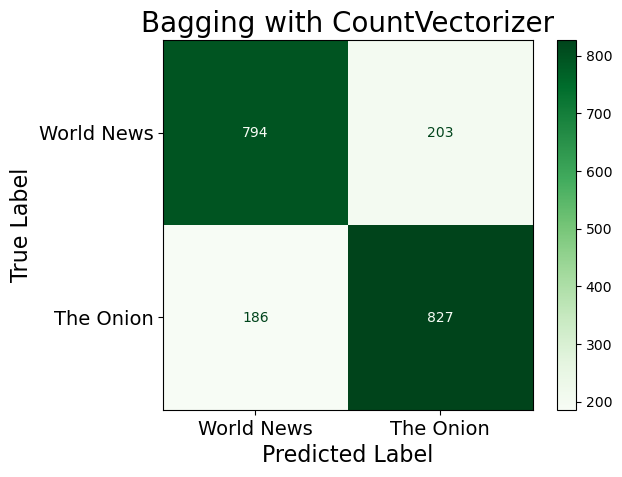

In [86]:
# Creating Metrics
tn_bag_cvec, fp_bag_cvec, fn_bag_cvec, tp_bag_cvec = confusion_matrix(y_test, preds_bag_cvec).ravel()

'''
NOTE:  Negative class is TheOnion as it is alphabetically first and thus the positive class is worldnews
'''

# Setting Up Confusion Matrix
#  Source for color map name:  https://i.stack.imgur.com/cmk1J.png
ConfusionMatrixDisplay.from_estimator(bag_pipe_cvec, X_test, y_test, display_labels=['World News', 'The Onion'], cmap = 'Greens');
plt.title('Bagging with CountVectorizer', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show();

# Other

# Eventually run this towards the end